# Project_훈2
## 프로젝트 개요
효율적인 재고관리를 위한 상품 판매량 예측이 초기 주제였으나, 판매 데이터를 이용하지 않고 리뷰 데이터를 이용한 판매량 대비 리뷰 증감 수 예측을 진행한다.

### 프로젝트 주제
네이버 쇼핑 전체 카테고리 상품 리뷰 수 예측 모델

### 프로젝트 목표
- 판매량 대비 리뷰 증감수를 타겟으로 하는 회귀 및 시계열 예측 모델 구축
- 예측 결과를 이용한 판매량 예측

### 프로젝트 기대효과
1. 재고관리 효율성 및 기업 이익 증대
2. 경쟁사 매출 분석을 통해 마케팅 전략 수립 가능

### 프로젝트 구성
- 데이터 수집
- 데이터 전처리
- 데이터 시각화
- 머신러닝 모델링 (Linear Regression, Lasso, Ridge, ElasticNet, SVM, Decision Tree, RandomForest, LightGBM, XGBoost, Gradient Boosting Regressor)
- 앙상블 모델링 (Averaging, Stacking)

## 데이터 전처리

In [1]:
# 사용 모듈 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-white')
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import pickle
import joblib
from sklearn.preprocessing import LabelEncoder

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# 전처리 함수 만들기
# 변수 삭제 전처리 함수
def dropcol(df) : # '등록일자', '리뷰건수', '찜하기수' 미포함
    df.drop(['수집일자', '등록일자', '카테고리세분류', '상품명', '판매자', '리뷰건수', '구매건수',
             '이미지url', '이미지사이즈', '이미지컬러코드'], axis=1, inplace=True) 
    return df
# 변수 텍스트 / 결측치 / 범주화 전처리 함수
def encodecol(df):
    df['판매자등급'] = df['판매자등급'].str.extract(pat = '([0-9]$)').astype(int)
    df['굿서비스'] = df['굿서비스'].astype(int)
    df['적립포인트'] = df['적립포인트'].str.extract(pat = '([0-9]+)').astype(int)
    df['배송정보'] = df['배송정보'].str.extract(pat = '([오]...)')
    df['배송정보'] = df['배송정보'].apply(lambda x: 1 if str(x) == '오늘출발' else 0)
    df['검색키워드'] = df['검색키워드'].notnull().astype(int)
    df['태그'] = df['태그'].apply(lambda x : len(str(x).split(',')) if str(x) != 'nan' else 0)
    df['배송비'] = df['배송비'].apply(lambda x: 0 if x == 0 else 1)
    df['찜하기수'] = df['찜하기수'].fillna(0)
    df['평점'] = df['평점'].fillna(0)
    return df

# 라벨 인코더 전처리 함수
def lecol(df):
    features = ['카테고리대분류', '카테고리중분류', '카테고리소분류']
    for f in features:
        le = LabelEncoder()
        le.fit(df.loc[:,f])
        df.loc[:,f] = le.transform(df.loc[:,f])
    return df

# 파생변수 추가 전처리 함수
def derivedvar(df) :
    df['수집일자'] = df['수집일자'].str[:10].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))
    df['등록일자'] = df['등록일자'].astype('str').str[:8].apply(lambda x: datetime.strptime(x,"%Y%m%d"))
    df['판매기간(주)'] = (df['수집일자']-df['등록일자']).dt.days//7
    df['페이지'] = np.digitize(df['순위'], range(1,440, 40))
    return df

In [3]:
# 최종 전처리
def preprocessing(df):
    df = derivedvar(df)
    df = dropcol(df)
    df = encodecol(df)
    df = lecol(df)
    return df

## 데이터 구성
상품별 리뷰 수의 일주일 증감치를 타겟으로 두기 때문에 일주일 후의 데이터에서 현재의 데이터를 빼 증감치를 구하는 형식으로 데이터를 구성한다.

    ex)
    12/17 - 12/10 = df1
    12/24 - 12/17 = df2
    12/31 - 12/24 = df3
    df1 + df2 + df3 = 최종 데이터프레임

In [4]:
# 12/10 ~ 12/17 데이터프레임 만들기
df1 = pd.read_csv(
    'G:/내 드라이브/프로젝트/아자아자2조유통파이팅~!/data/shopping/전체카테고리_20211210.csv')
df2 = pd.read_csv(
    'G:/내 드라이브/프로젝트/아자아자2조유통파이팅~!/data/shopping/전체카테고리_20211217.csv')
df = pd.concat([df1, df2])
df.reset_index(inplace=True, drop=True)

# 12/10과 12/17에 우리가 쓸 변수의 모든 값이 중복인 상품의 id를 idlist에 담기
df = preprocessing(df)
df = df[df.duplicated([
    '상품아이디', '카테고리대분류', '카테고리중분류', '카테고리소분류', '가격', '판매자등급', '굿서비스', '이벤트유무',
    '배송비', '배송정보', '적립포인트', '검색키워드', '태그', '추가이미지개수', '비디오유무', '평점'
],
                      keep='last')]
idlist = list(df['상품아이디'].unique())

# merge해서 idlist에 있는 상품만 가지고 오기
df_1 = pd.merge(df, preprocessing(df2)[['상품아이디','리뷰건수합', '페이지', '찜하기수', '쿠폰유무']], how='inner', on='상품아이디')
df_1 = df_1.query('상품아이디 == @idlist')

# 파생변수 추가
# df_1['페이지증감'] = df_1['페이지_x'] - df_1['페이지_y']
# df_1['찜하기수증감'] = df_1['찜하기수_y'] - df_1['찜하기수_x']
df_1['리뷰건수증감'] = df_1['리뷰건수합_y'] - df_1['리뷰건수합_x']
df_1['쿠폰유무변화'] = df_1['쿠폰유무_x'] + df_1['쿠폰유무_y']
df_1['쿠폰유무변화'] = df_1['쿠폰유무변화'].apply(lambda x: 1 if x == 1 else 0)
df_1['크리스마스'] = 2

# 필요없는컬럼 제거
df_1 = df_1.drop(['순위','리뷰건수합_y','리뷰건수합_x','페이지_x','페이지_y','찜하기수_x','찜하기수_y','쿠폰유무_x', '쿠폰유무_y'], axis=1)
df_1

,카테고리대분류,카테고리중분류,카테고리소분류,상품아이디,판매자등급,굿서비스,가격,이벤트유무,배송비,배송정보,적립포인트,평점,검색키워드,태그,추가이미지개수,비디오유무,판매기간(주),리뷰건수증감,쿠폰유무변화,크리스마스
0,8,32,592,83477819660,3,0,99000,0,1,0,990,4.8,0,5,6,0,7,42,0,2
1,8,32,592,83548281046,2,1,109700,0,0,0,1097,4.9,0,4,2,0,3,198,1,2
2,8,31,381,81193080648,2,1,9900,0,1,0,99,4.6,0,7,1,0,165,333,0,2
3,8,32,592,83542825647,6,0,254000,0,1,0,2540,4.9,0,4,5,0,4,15,0,2
4,8,111,145,82237690733,3,0,18900,0,1,0,189,4.6,0,8,9,0,10,53,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,1,171,650,82552623066,3,1,2700,0,1,1,127,4.8,0,9,0,0,74,7,0,2
2806,1,89,662,82082215428,4,1,13500,0,0,0,235,4.8,0,9,8,0,131,2,0,2
2807,1,89,64,82641621108,3,1,15300,0,0,0,153,4.9,0,2,0,0,66,12,1,2
2808,1,168,627,82471146375,3,1,14400,0,0,0,344,4.8,0,10,6,0,82,2,1,2


In [5]:
# 12/17 ~ 12/24 데이터프레임 만들기
df1 = pd.read_csv('G:/내 드라이브/프로젝트/아자아자2조유통파이팅~!/data/shopping/전체카테고리_20211217.csv')
df2 = pd.read_csv('G:/내 드라이브/프로젝트/아자아자2조유통파이팅~!/data/shopping/전체카테고리_20211224.csv')
df = pd.concat([df1, df2])
df.reset_index(inplace=True, drop=True)

# 12/10과 12/17에 우리가 쓸 변수의 모든 값이 중복인 상품의 id를 idlist에 담기
df = preprocessing(df)
df = df[df.duplicated([
    '상품아이디', '카테고리대분류', '카테고리중분류', '카테고리소분류', '가격', '판매자등급', '굿서비스', '이벤트유무',
    '배송비', '배송정보', '적립포인트', '검색키워드', '태그', '추가이미지개수', '비디오유무', '평점'
],
                      keep='last')]
idlist = list(df['상품아이디'].unique())

# merge해서 idlist에 있는 상품만 가지고 오기
df_2 = pd.merge(df, preprocessing(df2)[['상품아이디','리뷰건수합', '페이지', '찜하기수', '쿠폰유무']], how='inner', on='상품아이디')
df_2 = df_2.query('상품아이디 == @idlist')

# 파생변수 추가
# df_2['페이지증감'] = df_2['페이지_x'] - df_2['페이지_y']
# df_2['찜하기수증감'] = df_2['찜하기수_y'] - df_2['찜하기수_x']
df_2['리뷰건수증감'] = df_2['리뷰건수합_y'] - df_2['리뷰건수합_x']
df_2['쿠폰유무변화'] = df_2['쿠폰유무_x'] + df_2['쿠폰유무_y']
df_2['쿠폰유무변화'] = df_2['쿠폰유무변화'].apply(lambda x: 1 if x == 1 else 0)
df_2['크리스마스'] = 1

# 필요없는컬럼 제거
df_2 = df_2.drop(['순위','리뷰건수합_y','리뷰건수합_x','페이지_x','페이지_y','찜하기수_x','찜하기수_y','쿠폰유무_x', '쿠폰유무_y'], axis=1)
df_2

,카테고리대분류,카테고리중분류,카테고리소분류,상품아이디,판매자등급,굿서비스,가격,이벤트유무,배송비,배송정보,적립포인트,평점,검색키워드,태그,추가이미지개수,비디오유무,판매기간(주),리뷰건수증감,쿠폰유무변화,크리스마스
0,8,32,581,83548281046,2,1,109700,0,0,0,1097,4.9,0,4,2,0,4,158,0,1
1,8,108,558,81729889372,3,1,16900,0,1,0,169,4.2,0,6,9,0,148,201,0,1
2,8,109,139,82237690733,3,0,18900,0,1,0,189,4.6,0,8,9,0,11,51,0,1
3,8,32,581,83542825647,6,0,254000,0,1,0,2540,4.9,0,4,5,0,5,16,0,1
4,8,32,581,83548272147,2,1,159800,0,0,0,1598,5.0,0,4,3,0,2,95,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,1,126,517,10367829948,3,1,10740,0,0,0,226,4.7,0,5,1,0,273,4,0,1
2801,1,170,635,81662247442,2,1,8910,0,0,0,178,4.7,0,6,9,0,26,3,0,1
2802,1,87,44,82492741685,3,1,29700,0,0,0,297,4.9,0,0,1,0,7,2,0,1
2803,1,14,330,82840902096,3,0,13410,0,0,0,134,4.8,0,0,0,0,51,4,0,1


In [6]:
# 12/24 ~ 12/31 데이터프레임 만들기
df1 = pd.read_csv('G:/내 드라이브/프로젝트/아자아자2조유통파이팅~!/data/shopping/전체카테고리_20211224.csv')
df2 = pd.read_csv('G:/내 드라이브/프로젝트/아자아자2조유통파이팅~!/data/shopping/전체카테고리_20211231.csv')
df = pd.concat([df1, df2])
df.reset_index(inplace=True, drop=True)

# 12/10과 12/17에 우리가 쓸 변수의 모든 값이 중복인 상품의 id를 idlist에 담기
df = preprocessing(df)
df = df[df.duplicated([
    '상품아이디', '카테고리대분류', '카테고리중분류', '카테고리소분류', '가격', '판매자등급', '굿서비스', '이벤트유무',
    '배송비', '배송정보', '적립포인트', '검색키워드', '태그', '추가이미지개수', '비디오유무', '평점'
],
                      keep='last')]
idlist = list(df['상품아이디'].unique())

# merge해서 idlist에 있는 상품만 가지고 오기
df_3 = pd.merge(df, preprocessing(df2)[['상품아이디','리뷰건수합', '페이지', '찜하기수', '쿠폰유무']], how='inner', on='상품아이디')
df_3 = df_3.query('상품아이디 == @idlist')

# 파생변수 추가
# df_3['페이지증감'] = df_3['페이지_x'] - df_3['페이지_y']
# df_3['찜하기수증감'] = df_3['찜하기수_y'] - df_3['찜하기수_x']
df_3['리뷰건수증감'] = df_3['리뷰건수합_y'] - df_3['리뷰건수합_x']
df_3['쿠폰유무변화'] = df_3['쿠폰유무_x'] + df_3['쿠폰유무_y']
df_3['쿠폰유무변화'] = df_3['쿠폰유무변화'].apply(lambda x: 1 if x == 1 else 0)
df_3['크리스마스'] = 0

# 필요없는컬럼 제거
df_3 = df_3.drop(['순위','리뷰건수합_y','리뷰건수합_x','페이지_x','페이지_y','찜하기수_x','찜하기수_y','쿠폰유무_x', '쿠폰유무_y'], axis=1)
df_3

,카테고리대분류,카테고리중분류,카테고리소분류,상품아이디,판매자등급,굿서비스,가격,이벤트유무,배송비,배송정보,적립포인트,평점,검색키워드,태그,추가이미지개수,비디오유무,판매기간(주),리뷰건수증감,쿠폰유무변화,크리스마스
0,8,32,580,83542825647,6,0,254000,0,1,0,2540,4.9,0,4,5,0,6,20,0,0
1,8,32,580,83548281046,2,1,109700,0,0,0,1097,4.9,0,4,2,0,5,112,1,0
2,8,107,237,83485513012,3,0,14800,0,0,0,148,4.7,0,2,0,0,9,140,0,0
3,8,31,738,82902367973,3,1,38800,0,0,1,388,4.7,0,5,4,0,47,166,0,0
4,8,32,678,82138703883,3,0,149000,0,0,0,1490,4.8,0,5,3,1,9,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,1,86,671,81468183722,3,1,18000,0,0,1,190,4.8,0,2,8,0,158,0,1,0
2846,1,163,614,9420669865,3,1,9900,0,0,1,297,4.8,0,8,1,0,47,6,0,0
2847,1,86,66,82356126910,3,0,36900,0,0,0,369,4.7,0,9,0,0,98,6,1,0
2848,1,157,32,6726944842,3,0,18000,1,0,1,180,4.9,0,2,0,0,467,3,1,0


In [7]:
df = pd.concat([df_1, df_2, df_3])
outlier = list(df[df['리뷰건수증감']<0]['상품아이디'].unique())
df = df.query('상품아이디 != @outlier')
df = df.drop('상품아이디', axis = 1)
df.reset_index(inplace=True, drop=True); df

,카테고리대분류,카테고리중분류,카테고리소분류,판매자등급,굿서비스,가격,이벤트유무,배송비,배송정보,적립포인트,평점,검색키워드,태그,추가이미지개수,비디오유무,판매기간(주),리뷰건수증감,쿠폰유무변화,크리스마스
0,8,32,592,3,0,99000,0,1,0,990,4.8,0,5,6,0,7,42,0,2
1,8,32,592,2,1,109700,0,0,0,1097,4.9,0,4,2,0,3,198,1,2
2,8,31,381,2,1,9900,0,1,0,99,4.6,0,7,1,0,165,333,0,2
3,8,32,592,6,0,254000,0,1,0,2540,4.9,0,4,5,0,4,15,0,2
4,8,111,145,3,0,18900,0,1,0,189,4.6,0,8,9,0,10,53,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8415,1,86,671,3,1,18000,0,0,1,190,4.8,0,2,8,0,158,0,1,0
8416,1,163,614,3,1,9900,0,0,1,297,4.8,0,8,1,0,47,6,0,0
8417,1,86,66,3,0,36900,0,0,0,369,4.7,0,9,0,0,98,6,1,0
8418,1,157,32,3,0,18000,1,0,1,180,4.9,0,2,0,0,467,3,1,0


In [8]:
# 데이터 저장
# df.to_csv('finaldf.csv', index=False, encoding='UTF-8 sig')

In [9]:
test_df = pd.read_csv('0103_0110.csv')
test_df = test_df.drop(['찜하기수증감', '페이지증감'], axis=1); test_df

,카테고리대분류,카테고리중분류,카테고리소분류,상품아이디,판매자등급,굿서비스,가격,이벤트유무,배송비,배송정보,적립포인트,평점,검색키워드,태그,추가이미지개수,비디오유무,판매기간(주),리뷰건수증감,쿠폰유무변화,크리스마스
0,8,32,595,83542825647,3,0,254000,0,1,0,2540,4.9,0,4,5,0,7,7,0,9
1,8,32,595,83548281046,3,0,109700,0,0,0,1097,4.9,0,4,2,0,6,97,0,9
2,8,32,698,82138703883,3,0,149000,0,0,0,1490,4.8,0,5,3,1,11,23,0,9
3,8,32,237,83221694282,3,0,18700,0,1,0,187,4.7,0,2,8,0,27,156,0,9
4,8,108,237,82796977545,3,0,20900,0,0,0,209,4.6,0,3,0,0,12,32,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,1,88,43,82264181984,3,0,33300,1,0,0,743,4.7,0,3,9,0,51,0,0,9
2761,1,88,691,81468183722,3,1,18000,0,0,1,280,4.8,0,2,8,0,159,8,0,9
2762,1,123,528,82105843751,3,0,19800,0,0,0,198,4.7,0,0,0,0,132,7,0,9
2763,1,140,546,82986209241,3,1,29700,0,0,0,397,4.9,0,3,2,0,1,4,0,9


## EDA

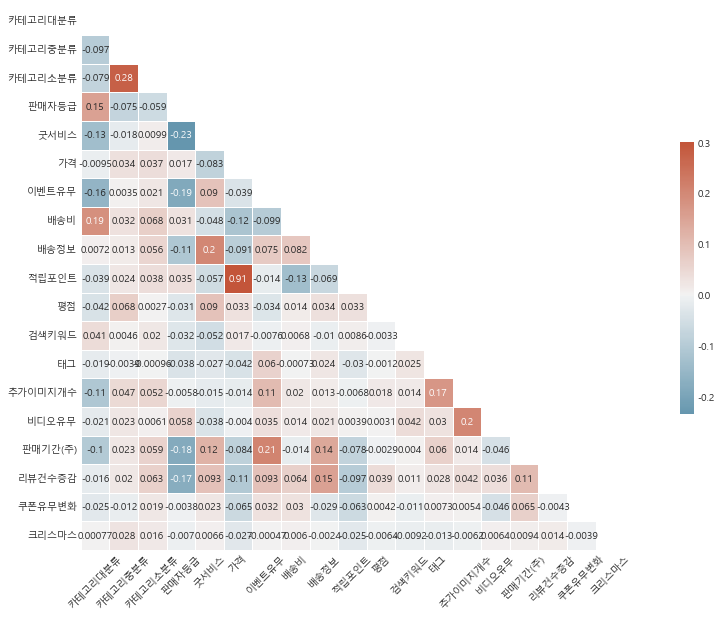

In [10]:
# 변수간 상관관계
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(20,10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.xticks(rotation=45)
plt.show()

## 모델링

### 데이터 분리

In [11]:
# 사용 모듈 임포트
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import catboost

In [12]:
# 타겟변수(y)와 독립변수(x) 분리
y = df.loc[:, '리뷰건수증감']
x = df.drop('리뷰건수증감', axis = 1)

In [14]:
# train_test_split을 이용하여 학습 데이터와 검증 데이터 랜덤 분리
x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y,
                                                  test_size=0.3,
                                                  train_size=0.7,
                                                  shuffle=True,
                                                  random_state=42)
y_test = test_df.loc[:, '리뷰건수증감']
x_test = test_df.drop(['상품아이디', '리뷰건수증감'], axis=1)

In [16]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(5894, 18)
(2526, 18)
(2765, 18)


In [17]:
# KFold 지정
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### Linear Regression

In [18]:
scoring = {'R2 score' : 'r2', 'Neg RMSE' : 'neg_root_mean_squared_error', 'Neg RMSLE' : 'neg_mean_squared_log_error'}

In [19]:
lm = LinearRegression()
lm.fit(x_train, y_train)

lm_r2score = lm.score(x_val, y_val) # 결정계수 R^2 score
lm_rmse = mean_squared_error(y_val, lm.predict(x_val), squared=False) # RMSE
print(f'R2 score : {lm_r2score}, RMSE : {lm_rmse}')

R2 score : 0.07414010031848417, RMSE : 221.252343926426


In [20]:
lm_r2score = lm.score(x_test, y_test) # 결정계수 R^2 score
lm_rmse = mean_squared_error(y_test, lm.predict(x_test), squared=False) # RMSE
print(f'R2 score : {lm_r2score}, RMSE : {lm_rmse}')

R2 score : 0.03222638693345781, RMSE : 235.88650420085523


### Lasso, Ridge

In [21]:
lasso = Lasso(random_state=42)
lasso.fit(x_train, y_train)

lasso_r2score = lasso.score(x_test, y_test) # 결정계수 R^2 score
lasso_rmse = mean_squared_error(y_test, lasso.predict(x_test), squared=False) # RMSE
print(f'R2 score : {lasso_r2score}, RMSE : {lasso_rmse}')

R2 score : 0.048602786677527154, RMSE : 233.88218551557756


In [22]:
lasso_r2score = lasso.score(x_val, y_val) # 결정계수 R^2 score
lasso_rmse = mean_squared_error(y_val, lasso.predict(x_val), squared=False) # RMSE
print(f'R2 score : {lasso_r2score}, RMSE : {lasso_rmse}')

R2 score : 0.07322658152113237, RMSE : 221.36146861352324


In [23]:
ridge = Ridge(alpha=0.1, random_state=42)

ridge.fit(x_train,y_train)
ridge_r2score = ridge.score(x_test, y_test) # 결정계수 R^2 score
ridge_rmse = mean_squared_error(y_test, ridge.predict(x_test), squared=False) # RMSE
print(f'R2 score : {ridge_r2score}, RMSE : {ridge_rmse}')

R2 score : 0.032227948657993055, RMSE : 235.88631387230896


In [24]:
ridge_r2score = ridge.score(x_val, y_val) # 결정계수 R^2 score
ridge_rmse = mean_squared_error(y_val, ridge.predict(x_val), squared=False) # RMSE
print(f'R2 score : {ridge_r2score}, RMSE : {ridge_rmse}')

R2 score : 0.07414010109223212, RMSE : 221.2523438339749


### ElasticNet, SVM

In [25]:
en = ElasticNet(random_state=42)
en.fit(x_train, y_train)

en_r2score = en.score(x_test, y_test) # 결정계수 R^2 score
en_rmse = mean_squared_error(y_test, en.predict(x_test), squared=False) # RMSE
print(f'R2 score : {en_r2score}, RMSE : {en_rmse}')

# y_pred_en = en.predict(x_test)
# y_pred_en = pd.DataFrame(y_pred_en, columns=['예측값'])
# result_en = pd.concat([test_odf['상품아이디'], y_test, y_pred_en], axis=1); result_en

R2 score : 0.04236475710484999, RMSE : 234.6476808727943


In [26]:
svr = SVR()
svr.fit(x_train, y_train)

svr_r2score = svr.score(x_test, y_test) # 결정계수 R^2 score
svr_rmse = mean_squared_error(y_test, svr.predict(x_test), squared=False) # RMSE
print(f'R2 score : {svr_r2score}, RMSE : {svr_rmse}')

R2 score : -0.0409849896479193, RMSE : 244.64618038778255


### Decision Tree

In [27]:
# dt = DecisionTreeRegressor(random_state=42)
# parameters = {
#     "max_depth": [70, 75, 80, 30],
#     "min_samples_split": [5, 6, 7, 8],
#     'max_leaf_nodes': [40, 45, 50, 60],
#     'min_samples_leaf': [25, 20, 27, 28, 29],
#     'splitter': ['best', 'random'],
#     'max_features' : ['auto', 'sqrt', 'log2']
# }

# dtr = RandomizedSearchCV(dt,
#                           param_distributions=parameters,
#                           cv=kfold,
#                           scoring='r2')
# dtr.fit(x_train, y_train)

# dt_r2score = dtr.score(x_val, y_val) # 결정계수 R^2 score
# dt_rmse = mean_squared_error(y_val, dtr.predict(x_val), squared=False) # RMSE
# print(f'R2 score : {dt_r2score}, RMSE : {dt_rmse}')

# y_pred_dt = dt.predict(x_val)
# y_pred_dt = pd.DataFrame(y_pred_dt, columns=['예측값'])
# result_dt = pd.concat([val_odf['상품아이디'], y_val, y_pred_dt], axis=1); result_dt

In [28]:
# dtr.best_estimator_

In [29]:
dt_best = DecisionTreeRegressor(max_depth=75,
                           max_features='auto',
                           max_leaf_nodes=40,
                           min_samples_leaf=28,
                           min_samples_split=6,
                           random_state=42)
dt_best.fit(x_train, y_train)
r2_score(y_val, dt_best.predict(x_val))

0.42576268460053157

In [30]:
dt_r2score = r2_score(y_test, dt_best.predict(x_test)) # 결정계수 R^2 score
dt_rmse = mean_squared_error(y_test, dt_best.predict(x_test), squared=False) # RMSE
print(f'R2 score : {dt_r2score}, RMSE : {dt_rmse}')

R2 score : 0.3966580636762228, RMSE : 186.25072086688772


### RandomForest

In [31]:
# rf = RandomForestRegressor(random_state=42)

# parameters = {
#     "n_estimators": [100, 200, 300],
#     "criterion": ['mse', 'mae'],
#     "max_depth": [30, 25, 40],
#     "min_samples_split": [2, 3, 4],
#     'min_samples_leaf' : [1, 2, 3, 4],
#     'max_leaf_nodes': [5, 6, 7, 8],
# }

# rfr = RandomizedSearchCV(rf,
#                           param_distributions=parameters,
#                           cv=kfold,
#                           scoring='r2')
# rfr.fit(x_train, y_train)

# rf_r2score = rfr.score(x_val, y_val)  # 결정계수 R^2 score
# rf_rmse = mean_squared_error(y_val, rfr.predict(x_val), squared=False)  # RMSE
# print(f'R2 score : {rf_r2score}, RMSE : {rf_rmse}')

# y_pred_rf = rf.predict(x_val)
# y_pred_rf = pd.DataFrame(y_pred_rf, columns=['예측값'])
# result_rf = pd.concat([val_odf['상품아이디'], y_val, y_pred_rf], axis=1); result_rf

In [32]:
rf_best = RandomForestRegressor(random_state=42,
                           bootstrap=False,
                           max_features='sqrt',
                           min_samples_leaf=1,
                           n_estimators=700)
rf_best.fit(x_train, y_train)
rf_r2score = r2_score(y_val, rf_best.predict(x_val))
rf_rmse = mean_squared_error(y_val, rf_best.predict(x_val), squared=False) # RMSE
print(f'R2 score : {rf_r2score}, RMSE : {rf_rmse}')

R2 score : 0.8376586042248917, RMSE : 92.64668422812768


In [33]:
rf_r2score = r2_score(y_test, rf_best.predict(x_test))
rf_rmse = mean_squared_error(y_test, rf_best.predict(x_test), squared=False) # RMSE
print(f'R2 score : {rf_r2score}, RMSE : {rf_rmse}')

R2 score : 0.7934981721411379, RMSE : 108.96277524342797


In [34]:
# y_pred_rf_val = rf.predict(x_val)
# y_pred_rf = pd.DataFrame(y_pred_rf, columns=['prediction'])
# result_rf = pd.concat([y_val_copy, y_pred_rf], axis=1)
# result_rf['오차'] = abs(result_rf['리뷰건수증감'] - result_rf['prediction'])
# result_rf['오차비율'] = result_rf['오차'] / result_rf['prediction']
# result_rf.sort_values(by='오차비율', ascending=True)

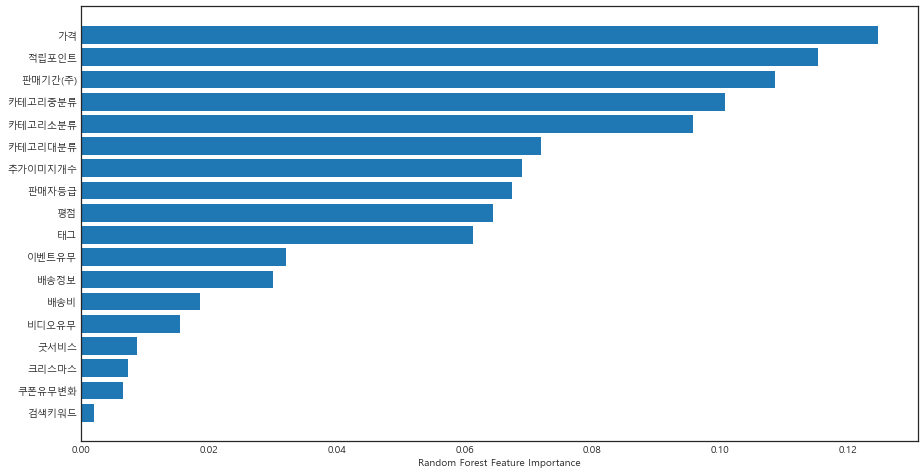

In [35]:
plt.figure(figsize=(15, 8))
sorted_idx = rf_best.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf_best.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

### XgBoost

In [36]:
# xgbr = XGBRegressor(n_estimators=1345,
#                     max_depth=11,
#                     min_child_weight=263,
#                     gamma=2,
#                     colsample_bytree=0.8,
#                     reg_lambda=1.7783618921553261,
#                     reg_alpha=0.495107774310335,
#                     subsample=0.6,
#                     random_state=42,
#                     tree_method='gpu_hist')
# xgbr = XGBRegressor(random_state=42, tree_method='gpu_hist')
# parameters = {
#     'n_estimators': [300, 400, 350],
#     'max_depth': [4, 5, 6, 7, 9, 10],
#     'min_child_weight': [1, 2, 3],
#     'gamma': [0, 0.5, 1],
#     'colsample_bytree': [1, 2, 3],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1]
# }
# n_iter_search = 10
# xgbr = RandomizedSearchCV(xgb,
#                           param_distributions=parameters,
#                           n_iter=n_iter_search,
#                           cv=kfold,
#                           scoring="r2")
# xgbr.fit(x_train, y_train)
# xgbr_r2score = r2_score(y_val, xgbr.predict(x_val)) # 결정계수 R^2 score
# xgbr_rmse = mean_squared_error(y_val,
#                                     xgbr.predict(x_val),
#                                     squared=False)  # RMSE
# print(f'R2 score : {xgbr_r2score}, RMSE : {xgbr_rmse}')

In [37]:
# xgbr.best_score_

In [38]:
# xgbr_best = xgbr.best_estimator_; xgbr_best

In [39]:
xgb_best= XGBRegressor(colsample_bytree=0.4,
                   learning_rate=0.05,
                   max_depth=10,
                   n_estimators=800,
                   random_state=42)
xgb_best.fit(x_train, y_train)
xgb_r2score = r2_score(y_val, xgb_best.predict(x_val))
xgb_rmse = mean_squared_error(y_val, xgb_best.predict(x_val), squared=False)
print(f'R2 score : {xgb_r2score}, RMSE : {xgb_rmse}')

R2 score : 0.8181625380728369, RMSE : 98.05210540987433


In [40]:
# xgb_optuna = XGBRegressor(n_estimators=2810,
#                    max_depth=8,
#                    min_child_weight=13,
#                    gamma=2,
#                    colsample_bytree=1.0,
#                    reg_lambda=0.0034896106282259003,
#                    alpha=6.914631756894438,
#                    subsample=0.7,
#                    random_state=42)
# xgb.fit(x_train, y_train)
# print(r2_score(y_val, xgb.predict(x_val)))
# print(mean_squared_error(y_val, xgb.predict(x_val), squared=False))

In [41]:
r2_score(y_test, xgb_best.predict(x_test)) # 결정계수 R^2 score
mean_squared_error(y_test, xgb_best.predict(x_test),
                               squared=False)  # RMSE

110.86466886058227

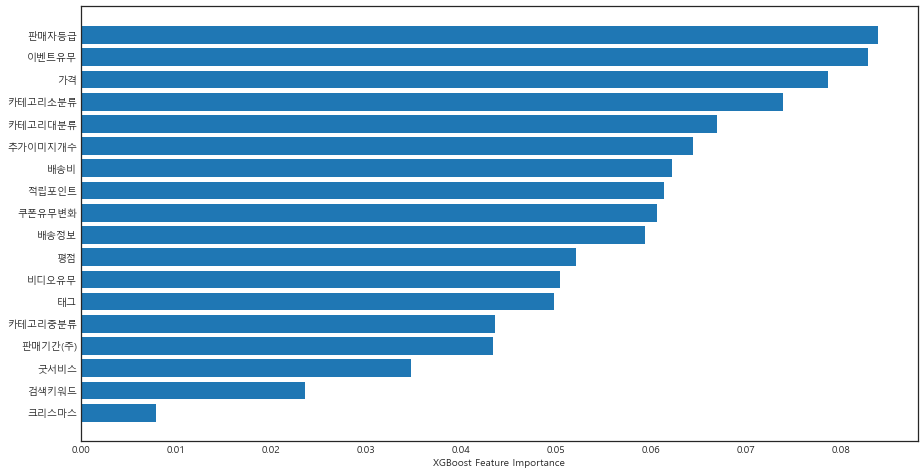

In [42]:
plt.figure(figsize=(15, 8))
sorted_idx = xgb_best.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], xgb_best.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.show()

### LightGBM

In [43]:
lgbm_best = LGBMRegressor(reg_alpha=0.10091737604591515,
                          reg_lambda=1.9138848042405095e-08,
                          num_leaves=40,
                          n_estimators=1489,
                          min_child_samples=48,
                          max_depth=9,
                          random_state=42)
lgbmfit = lgbm_best.fit(x_train, y_train)
lgbm_r2score = lgbm_best.score(x_val, y_val)  # 결정계수 R^2 score
lgbm_rmse = mean_squared_error(y_val, lgbm_best.predict(x_val),
                               squared=False)  # RMSE
print(f'R2 score : {lgbm_r2score}, RMSE : {lgbm_rmse}')

R2 score : 0.8035671055346741, RMSE : 101.91130221679363


In [44]:
lgbm_best_r2score = lgbm_best.score(x_test, y_test)  # 결정계수 R^2 score
lgbm_best_rmse = mean_squared_error(y_test,
                                      lgbm_best.predict(x_test),
                                      squared=False)  # RMSE
print(f'R2 score : {lgbm_best_r2score}, RMSE : {lgbm_best_rmse}')

R2 score : 0.7603056349201015, RMSE : 117.39378846714172


In [45]:
# lgbm = LGBMRegressor()
# parameters = {
#     'boosting_type' : ['gbdt', 'cart', 'goss'],
#     'n_estimators' : [250, 270, 260],
#     'max_depth': [9, 8, 10],
#     'min_child_weight': [0.001, 0.01, 0.1, 1],
#     'colsample_bytree': [1, 2, 3],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1]
# #     'reg_alpha' : [0.01, 0.001, 1, 0],
# #     'reg_lambda' : [0.01, 0.001, 1, 0]
# }
# n_iter_search = 20
# lgbmr = RandomizedSearchCV(lgbm,
#                           param_distributions=parameters,
#                           n_iter=n_iter_search,
#                           cv=kfold,
#                           scoring="r2")
# lgbmr.fit(x_train, y_train)

# lgbmr_r2score = lgbmr.score(x_val, y_val)  # 결정계수 R^2 score
# lgbmr_rmse = mean_squared_error(y_val, lgbmr.predict(x_val),
#                                squared=False)  # RMSE
# print(f'R2 score : {lgbmr_r2score}, RMSE : {lgbmr_rmse}')

In [46]:
# lgbm_best = lgbmr.best_estimator_; lgbm_best

In [47]:
# lgbm_r2score = lgbmr.score(x_test, y_test)  # 결정계수 R^2 score
# lgbm_rmse = mean_squared_error(y_test, lgbmr.predict(x_test),
#                                squared=False)  # RMSE
# print(f'R2 score : {lgbm_r2score}, RMSE : {lgbm_rmse}')

In [48]:
# y_pred_lgbmr = lgbmr.predict(x_val)
# y_pred_lgbmr = pd.DataFrame(y_pred_lgbmr, columns=['prediction'])
# result_lgbmr = pd.concat([y_test, y_pred_lgbmr], axis=1)
# result_lgbmr['오차'] = abs(result_lgbmr['리뷰건수증감'] - result_lgbmr['prediction'])
# result_lgbmr['오차비율'] = (result_lgbmr['오차'] / result_lgbmr['prediction'])
# result_lgbmr.sort_values(by='오차', ascending=False)

### Gradient Boosting Regressor

In [49]:
# gbr = GradientBoostingRegressor(random_state=42)
# parameters = {
#     'n_estimators' : [300, 250, 400, 350],
#     'learning_rate' : [0.1, 0.01, 0.02, 0.05],
#     'max_depth': [8, 9, 10, 11],
#     'min_samples_split': [5, 6],
#     'criterion': ['friedman_mse', 'squared_error', 'mse'],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1]
# #     'reg_alpha' : [0.01, 0.001, 1, 0],
# #     'reg_lambda' : [0.01, 0.001, 1, 0]
# }
# n_iter_search = 20
# gbrr = RandomizedSearchCV(gbr,
#                           param_distributions=parameters,
#                           n_iter=n_iter_search,
#                           cv=kfold,
#                           scoring="r2")
# gbrr.fit(x_train, y_train)
# # validation 평가
# gbr_r2score = gbrr.score(x_val, y_val) # 결정계수 R^2 score
# gbr_rmse = mean_squared_error(y_val, gbrr.predict(x_val), squared=False) # RMSE
# print(f'R2 score : {gbr_r2score}, RMSE : {gbr_rmse}')

In [50]:
# gbr_best = gbrr.best_estimator_; gbr_best

In [51]:
gbr_best = GradientBoostingRegressor(criterion='mse', max_depth=9, min_samples_split=5,
                          n_estimators=400, random_state=42, subsample=0.8)
gbr_best.fit(x_train, y_train)
# validation 평가
gbr_r2score = gbr_best.score(x_val, y_val) # 결정계수 R^2 score
gbr_rmse = mean_squared_error(y_val, gbr_best.predict(x_val), squared=False) # RMSE
print(f'R2 score : {gbr_r2score}, RMSE : {gbr_rmse}')

R2 score : 0.827877970371249, RMSE : 95.39672648494084


In [52]:
gbr_r2score = gbr_best.score(x_test, y_test) # 결정계수 R^2 score
gbr_rmse = mean_squared_error(y_test, gbr_best.predict(x_test), squared=False) # RMSE
print(f'R2 score : {gbr_r2score}, RMSE : {gbr_rmse}')

R2 score : 0.7446072006666941, RMSE : 121.17709312362221


### ML

In [56]:
results = pd.DataFrame({
    '모델': ['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet', 'SVM', 'Decision Tree', 'RandomForest', 'XGBoost', 'LightGBM', 'Gradient Boosting'],
    'r2 score': [lm_r2score, lasso_r2score, ridge_r2score, en_r2score, svr_r2score, dt_r2score, rf_r2score, xgb_r2score, lgbm_r2score, gbr_r2score],
    'RMSE': [lm_rmse, lasso_rmse, ridge_rmse, en_rmse, svr_rmse, dt_rmse, rf_rmse, xgb_rmse, lgbm_rmse, gbr_rmse]})
results.sort_values(by='RMSE', ascending=True)

,모델,r2 score,RMSE
7,XGBoost,0.818163,98.052105
8,LightGBM,0.803567,101.911302
6,RandomForest,0.793498,108.962775
9,Gradient Boosting,0.744607,121.177093
5,Decision Tree,0.396658,186.250721
2,Ridge,0.074140,221.252344
1,Lasso,0.073227,221.361469
3,ElasticNet,0.042365,234.647681
0,Linear Regression,0.032226,235.886504
4,SVM,-0.040985,244.646180


### Stacking-Averaging

In [57]:
y_pred_gbr = gbr_best.predict(x_val)
y_pred_xgb = xgb_best.predict(x_val)
y_pred_rf = rf_best.predict(x_val)
y_pred_gbr_test = gbr_best.predict(x_test)
y_pred_xgb_test = xgb_best.predict(x_test)
y_pred_rf_test = rf_best.predict(x_test)

In [58]:
display(y_pred_gbr)
display(y_pred_xgb)
display(y_pred_rf)
y_pred_gbr_test = gbr_best.predict(x_test)
y_pred_xgb_test = xgb_best.predict(x_test)
y_pred_rf_test = rf_best.predict(x_test)

array([ 37.95427479,  58.87338998, 106.71415075, ..., 143.49832656,
        39.67120067, 153.51346045])

array([ 40.61689,  43.66859, 144.10095, ..., 152.4631 ,  36.60611,
       152.4748 ], dtype=float32)

array([ 39.86428571,  47.65142857, 134.78761905, ..., 120.81857143,
        39.06714286, 162.78571429])

In [59]:
y_pred_avg2 = (y_pred_gbr + y_pred_rf) / 2; y_pred_avg2

array([ 38.90928025,  53.26240928, 120.7508849 , ..., 132.15844899,
        39.36917176, 158.14958737])

In [60]:
y_pred_avg2_test = (y_pred_gbr_test + y_pred_rf_test) / 2; y_pred_avg2_test

array([18.78600105, 64.57160367, 17.15786583, ..., 10.90796347,
       37.0552729 , 23.05150819])

In [61]:
y_pred_avg3 = (y_pred_gbr + y_pred_xgb + y_pred_rf) / 3; y_pred_avg3

array([ 39.47848348,  50.0644697 , 128.53424065, ..., 138.92666741,
        38.44815105, 156.25798907])

In [62]:
y_pred_avg3_test = (y_pred_gbr_test + y_pred_xgb_test + y_pred_rf_test) / 3; y_pred_avg3_test

array([16.47815344, 72.48141854, 22.52695994, ..., 10.40989698,
       35.24710264, 26.81724946])

In [63]:
avg2_r2score = r2_score(y_val, y_pred_avg2) # 결정계수 R^2 score
avg2_rmse = mean_squared_error(y_val, y_pred_avg2, squared=False) # RMSE
print(f'R2 score : {avg2_r2score}, RMSE : {avg2_rmse}')

R2 score : 0.8485168343416468, RMSE : 89.4947231991797


In [64]:
avg2_test_r2score = r2_score(y_test, y_pred_avg2_test) # 결정계수 R^2 score
avg2_test_rmse = mean_squared_error(y_test, y_pred_avg2_test, squared=False) # RMSE
print(f'R2 score : {avg2_test_r2score}, RMSE : {avg2_test_rmse}')

R2 score : 0.7854997746038963, RMSE : 111.052945598721


In [65]:
avg3_r2score = r2_score(y_val, y_pred_avg3) # 결정계수 R^2 score
avg3_rmse = mean_squared_error(y_val, y_pred_avg3, squared=False) # RMSE
print(f'R2 score : {avg3_r2score}, RMSE : {avg3_rmse}')

R2 score : 0.8477952814648853, RMSE : 89.70761306155072


In [66]:
avg3_test_r2score = r2_score(y_test, y_pred_avg3_test) # 결정계수 R^2 score
avg3_test_rmse = mean_squared_error(y_test, y_pred_avg3_test, squared=False) # RMSE
print(f'R2 score : {avg3_test_r2score}, RMSE : {avg3_test_rmse}')

R2 score : 0.7935648955521586, RMSE : 108.94517018032445


- 스태킹 모델 추가

In [67]:
import pickle, joblib
stc1 = joblib.load('stacking_model.pkl')
stc2 = joblib.load('G:/내 드라이브/프로젝트/아자아자2조유통파이팅~!/모델(피클)/stacking_model2.pkl')

In [68]:
stc1

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=StackingRegressor(meta_regressor=GradientBoostingRegressor(random_state=42),
                                         regressors=[RandomForestRegressor(random_state=42)]),
             n_jobs=-1,
             param_grid={'meta_regressor__learning_rate': [0.05],
                         'meta_regressor__max_depth': [7],
                         'meta_regressor__min_samples_leaf': [7],
                         'meta_regressor__min_samples_split': [5],
                         'meta_regressor__n_estimators': [1000],
                         'randomforestregressor__bootstrap': [False],
                         'randomforestregressor__max_depth': [None],
                         'randomforestregressor__max_features': ['sqrt'],
                         'randomforestregressor__min_samples_leaf': [1],
                         'randomforestregressor__n_estimators': [300]},
             scoring='neg_mean_squ

In [69]:
stc2

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=StackingRegressor(meta_regressor=LGBMRegressor(random_state=42),
                                         regressors=[RandomForestRegressor(random_state=42),
                                                     XGBRegressor(base_score=None,
                                                                  booster=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  enable_categorical=False,
                                                                  gamma=None,
                                                                  gpu_id=None,
                                                                  impor..

In [70]:
stc2.best_score_

-13638.168518550083

In [71]:
y_pred_stc1 = stc1.predict(x_val)
y_pred_stc1_test = stc1.predict(x_test)
y_pred_stc2 = stc2.predict(x_val)
y_pred_stc2_test = stc2.predict(x_test)

In [72]:
print(r2_score(y_test, stc1.predict(x_test)))
print(r2_score(y_test, stc2.predict(x_test)))

0.8012328977339167
0.8225936531971909


In [73]:
y_pred_avg2_stc1 = (y_pred_stc1 + y_pred_gbr + y_pred_rf) / 3; y_pred_avg2_stc1

array([ 39.60619564,  51.50827431, 126.83390075, ..., 129.10562477,
        38.9127892 , 164.76636438])

In [74]:
y_pred_avg2_stc2 = (y_pred_stc2 + y_pred_gbr + y_pred_rf) / 3; y_pred_avg2_stc2

array([ 39.26968562,  51.4953817 , 125.62908232, ..., 128.50700481,
        39.23972409, 159.27341373])

In [75]:
y_pred_avg2_stc1_test = (y_pred_stc1_test + y_pred_gbr_test + y_pred_rf_test) / 3; y_pred_avg2_stc1_test

array([17.5240244 , 60.38108844, 17.43859903, ..., 16.60532068,
       34.37019396, 24.36769301])

In [76]:
y_pred_avg2_stc2_test = (y_pred_stc2_test + y_pred_gbr_test + y_pred_rf_test) / 3; y_pred_avg2_stc2_test

array([18.18370285, 60.14290941, 17.4433664 , ..., 16.59502675,
       35.34092984, 21.37293745])

In [77]:
avg2_stc1_r2score = r2_score(y_val, y_pred_avg2_stc1) # 결정계수 R^2 score
avg2_stc1_rmse = mean_squared_error(y_val, y_pred_avg2_stc1, squared=False) # RMSE
print(f'R2 score : {avg2_stc1_r2score}, RMSE : {avg2_stc1_rmse}')

R2 score : 0.8487101133530517, RMSE : 89.43761133273937


In [78]:
avg2_stc1_test_r2score = r2_score(y_test, y_pred_avg2_stc1_test) # 결정계수 R^2 score
avg2_stc1_test_rmse = mean_squared_error(y_test, y_pred_avg2_stc1_test, squared=False) # RMSE
print(f'R2 score : {avg2_stc1_test_r2score}, RMSE : {avg2_stc1_test_rmse}')

R2 score : 0.7949244629034384, RMSE : 108.58582486097204


In [79]:
avg2_stc2_r2score = r2_score(y_val, y_pred_avg2_stc2) # 결정계수 R^2 score
avg2_stc2_rmse = mean_squared_error(y_val, y_pred_avg2_stc2, squared=False) # RMSE
print(f'R2 score : {avg2_stc2_r2score}, RMSE : {avg2_stc2_rmse}')

R2 score : 0.8520796042181384, RMSE : 88.43603706960461


In [80]:
avg2_stc2_test_r2score = r2_score(y_test, y_pred_avg2_stc2_test) # 결정계수 R^2 score
avg2_stc2_test_rmse = mean_squared_error(y_test, y_pred_avg2_stc2_test, squared=False) # RMSE
print(f'R2 score : {avg2_stc2_test_r2score}, RMSE : {avg2_stc2_test_rmse}')

R2 score : 0.8077096950330759, RMSE : 105.1465191512114


In [81]:
y_pred_avg3_stc1 = (y_pred_stc1 + y_pred_gbr + y_pred_xgb + y_pred_rf) / 4; y_pred_avg3_stc1

array([ 39.85886922,  49.54835337, 131.1506636 , ..., 134.94499464,
        38.3361193 , 161.69347141])

In [82]:
y_pred_avg3_stc1_test = (y_pred_stc1_test + y_pred_gbr_test + y_pred_xgb_test + y_pred_rf_test) / 4; y_pred_avg3_stc1_test

array([16.10863286, 67.3610784 , 21.39523632, ..., 14.80743151,
       33.68533599, 26.86295276])

In [83]:
y_pred_avg3_stc2 = (y_pred_stc2 + y_pred_gbr + y_pred_xgb + y_pred_rf) / 4; y_pred_avg3_stc2

array([ 39.60648671,  49.53868391, 130.24704978, ..., 134.49602967,
        38.58132047, 157.57375842])

In [84]:
y_pred_avg3_stc2_test = (y_pred_stc2_test + y_pred_gbr_test + y_pred_xgb_test + y_pred_rf_test) / 4; y_pred_avg3_stc2_test

array([16.60339169, 67.18244413, 21.39881184, ..., 14.79971106,
       34.41338791, 24.61688608])

In [85]:
avg3_stc1_r2score = r2_score(y_val, y_pred_avg3_stc1) # 결정계수 R^2 score
avg3_stc1_rmse = mean_squared_error(y_val, y_pred_avg3_stc1, squared=False) # RMSE
print(f'R2 score : {avg3_stc1_r2score}, RMSE : {avg3_stc1_rmse}')

R2 score : 0.8472861063472371, RMSE : 89.85753859463263


In [86]:
avg3_stc1_test_r2score = r2_score(y_test, y_pred_avg3_stc1_test) # 결정계수 R^2 score
avg3_stc1_test_rmse = mean_squared_error(y_test, y_pred_avg3_stc1_test, squared=False) # RMSE
print(f'R2 score : {avg3_stc1_test_r2score}, RMSE : {avg3_stc1_test_rmse}')

R2 score : 0.7979209182072329, RMSE : 107.7896063511267


In [87]:
avg3_stc2_r2score = r2_score(y_val, y_pred_avg3_stc2) # 결정계수 R^2 score
avg3_stc2_rmse = mean_squared_error(y_val, y_pred_avg3_stc2, squared=False) # RMSE
print(f'R2 score : {avg3_stc2_r2score}, RMSE : {avg3_stc2_rmse}')

R2 score : 0.8521721880030527, RMSE : 88.40835655747743


In [88]:
avg3_stc2_test_r2score = r2_score(y_test, y_pred_avg3_stc2_test) # 결정계수 R^2 score
avg3_stc2_test_rmse = mean_squared_error(y_test, y_pred_avg3_stc2_test, squared=False) # RMSE
print(f'R2 score : {avg3_stc2_test_r2score}, RMSE : {avg3_stc2_test_rmse}')

R2 score : 0.8086326133015784, RMSE : 104.89388456266236


In [89]:
y_pred = test_df[['상품아이디', '리뷰건수증감']]
y_pred.columns=['상품아이디', '실제값']
# y_pred['GBR_예측값'] = y_pred_gbr_test
# y_pred['XGB_예측값'] = y_pred_xgb_test
# y_pred['RF_예측값'] = y_pred_rf_test
# y_pred['stc1_예측값'] = y_pred_stc1_test
y_pred['회귀최종모델_예측값'] = y_pred_stc2_test
# y_pred['AVG2_GBR_RF_예측값'] = y_pred_avg2_test
# y_pred['AVG3_GBR_RF_XGB_예측값'] = y_pred_avg2_test
# y_pred['AVG2+stc1_예측값'] = y_pred_avg2_stc1_test
# y_pred['AVG3+stc1_예측값'] = y_pred_avg3_stc1_test
# y_pred['AVG2+stc2_예측값'] = y_pred_avg2_stc2_test
# y_pred['AVG3+stc2_예측값'] = y_pred_avg3_stc2_test
# y_pred['GBR_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['GBR_예측값'])  / y_pred['GBR_예측값']
# y_pred['XGB_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['XGB_예측값']) / y_pred['XGB_예측값']
# y_pred['RF_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['RF_예측값']) / y_pred['RF_예측값']
# y_pred['stc1_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['stc1_예측값']) / y_pred['stc1_예측값']
# y_pred['stc2_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['stc2_예측값']) / y_pred['stc2_예측값']
# y_pred['AVG2_GBR_RF_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['AVG2_GBR_RF_예측값']) / y_pred['AVG2_GBR_RF_예측값']
# y_pred['AVG3_GBR_RF_XGB_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['AVG3_GBR_RF_XGB_예측값']) / y_pred['AVG3_GBR_RF_XGB_예측값']
# y_pred['AVG2+stc1_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['AVG2+stc1_예측값']) / y_pred['AVG2+stc1_예측값']
# y_pred['AVG3+stc1_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['AVG3+stc1_예측값']) / y_pred['AVG3+stc1_예측값']
# y_pred['AVG2+stc2_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['AVG2+stc2_예측값']) / y_pred['AVG2+stc2_예측값']
# y_pred['AVG3+stc2_오차비율'] = abs(y_pred['리뷰건수증감'] - y_pred['AVG3+stc2_예측값']) / y_pred['AVG3+stc2_예측값']

# result_rf['오차'] = abs(result_rf['리뷰건수증감'] - result_rf['prediction'])
# result_rf['오차비율'] = result_rf['오차'] / result_rf['prediction']
# result_rf.sort_values(by='오차비율', ascending=True)

In [125]:
# 검증할 상품 리스트 생성
validlist = [82718019106, 83544591236, 83250021943, 83079049946, 83093376861, 81729997018, 83520531417, 83566853281, 83558923616, 83504388750,
             8325683452, 82717205816, 11781100542, 83157663150, 13305038227, 10022871025, 80023906035, 80951475879, 12823927460, 10173994686]

In [126]:
validdf = pd.DataFrame()
# df_1 = df_1.query('상품아이디 == @idlist')
validdf = y_pred.query('상품아이디 == @validlist')
validdf.reset_index(drop=True, inplace=True)
# validdf.set_index('상품아이디', inplace=True)
# validdf.sort_values(by='stc2_오차비율', ascending=True)

In [127]:
forecast = pd.read_csv('forecastresults.csv')

In [128]:
validdf = pd.merge(validdf, forecast, on='상품아이디', how='left')
# validdf = pd.merge(validdf, testid, on='상품아이디', how='left')

validdf.set_index(['상품아이디'], inplace=True); validdf

,실제값,회귀최종모델_예측값,AutoArima_예측값,Prophet_예측값,상품명
상품아이디,,,,,
80023906035,130,131.850804,102.000000,101.715218,반팔 티셔츠
83520531417,9,24.986382,13.000000,13.923776,파티룩 원피스
80951475879,509,442.611647,415.197488,460.122261,무지 양말
83566853281,35,65.013462,5.302089,30.499149,송혜교 귀걸이
12823927460,422,413.690687,416.610249,372.010764,메디힐 마스크팩
82717205816,4985,2965.294684,4919.464893,4806.217271,애플워치 스트랩
8325683452,454,369.548427,410.783335,316.882136,사무용 의자
10022871025,865,333.262478,408.000000,412.688829,유기농 아이과자
81729997018,108,146.814163,194.015341,119.327639,신생아 실내복


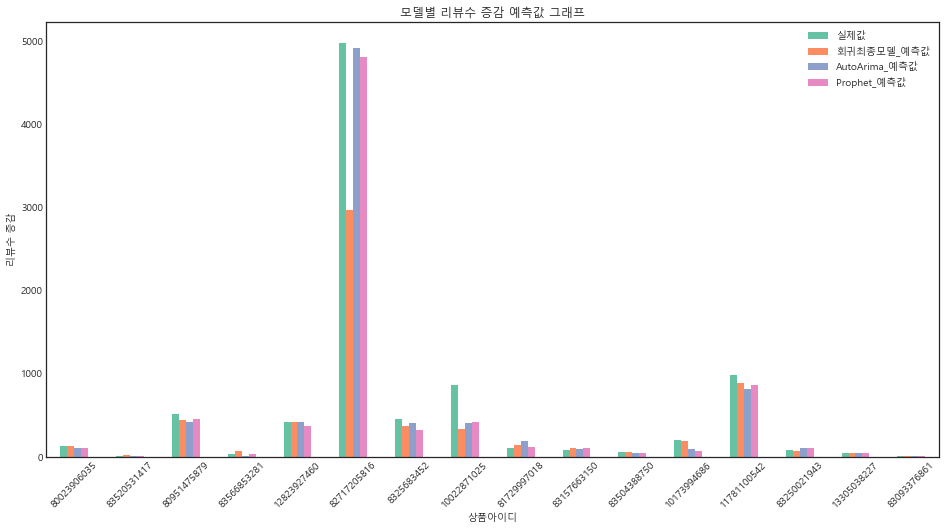

In [129]:
sns.set_palette('Set2')
validdf.plot(kind='bar', figsize=(16, 8))
plt.xticks(rotation=45)
plt.title('모델별 리뷰수 증감 예측값 그래프')
plt.ylabel('리뷰수 증감')
plt.show()

# plt.savefig('모델별 리뷰수 증감 예측값 그래프.png')

In [130]:
# clrs= {'실제값': ' #88d8b0', '회귀최종모델_예측값': '#ffeead', 'AutoArima_예측값': '#ff6f69', 'Prophet_예측값': '#ffcc5c'}
clrs= ['#88d8b0', '#ffeead', '#ff6f69','#ffcc5c']

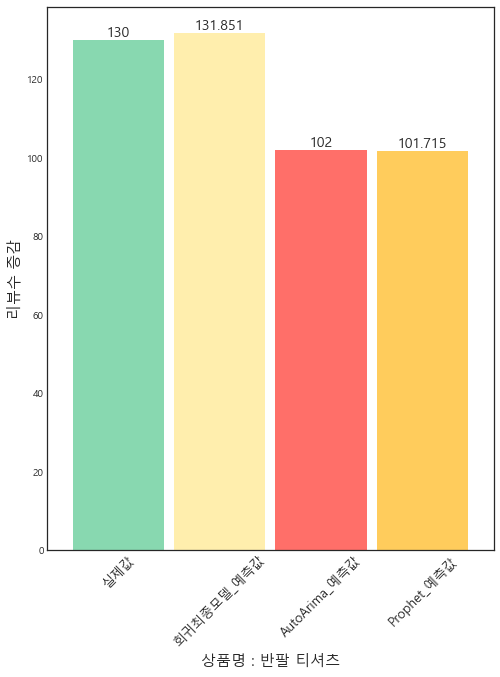

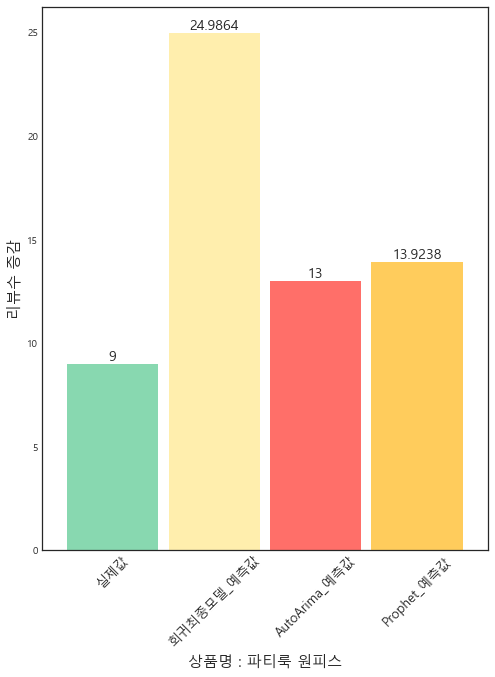

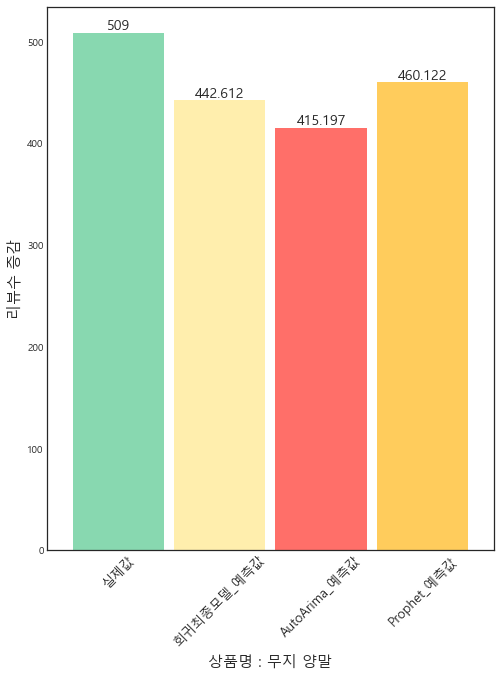

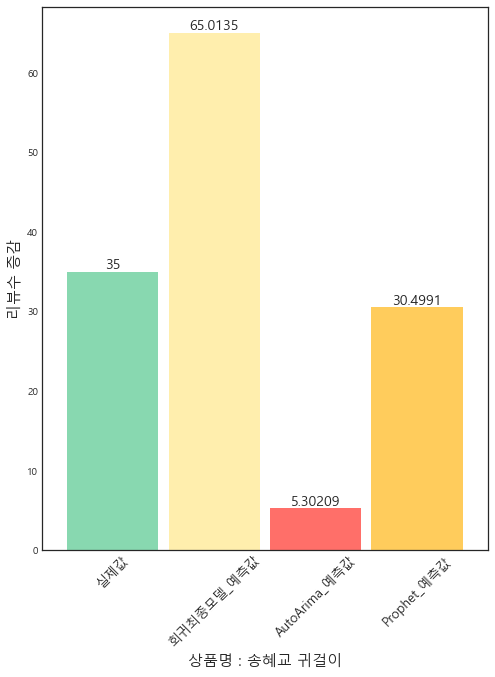

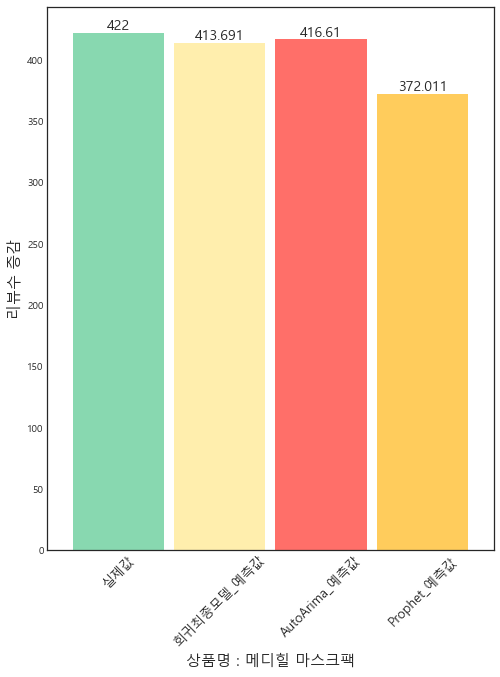

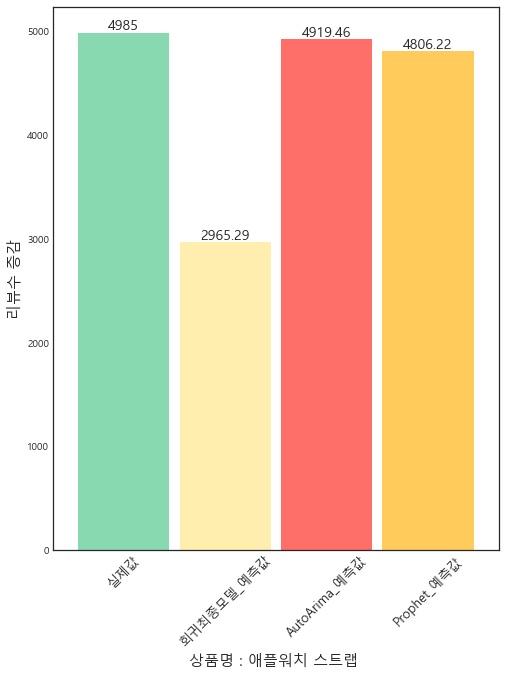

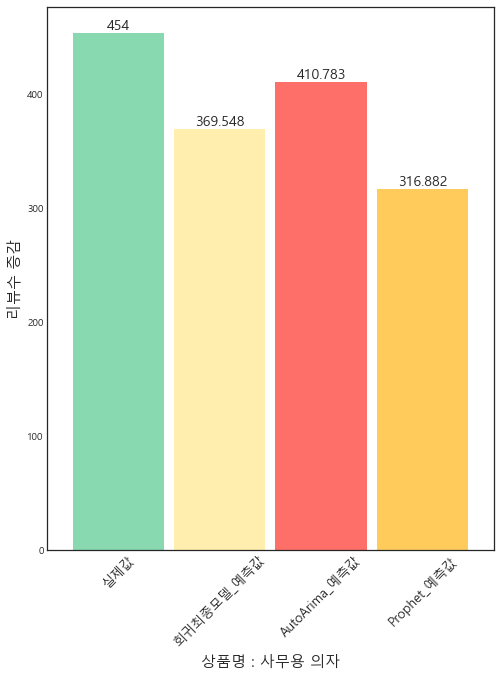

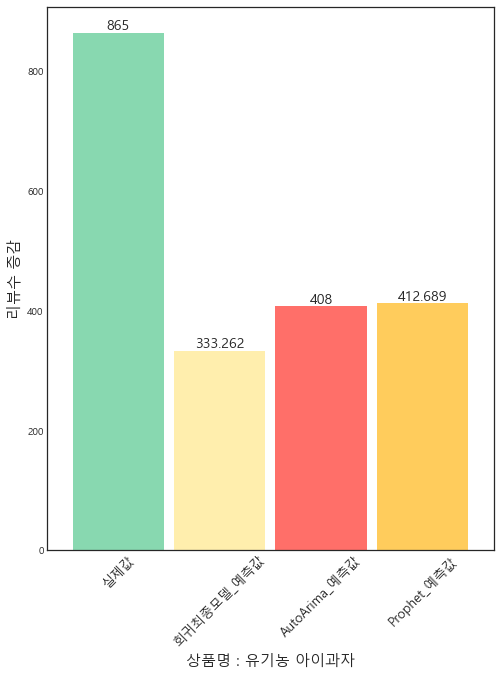

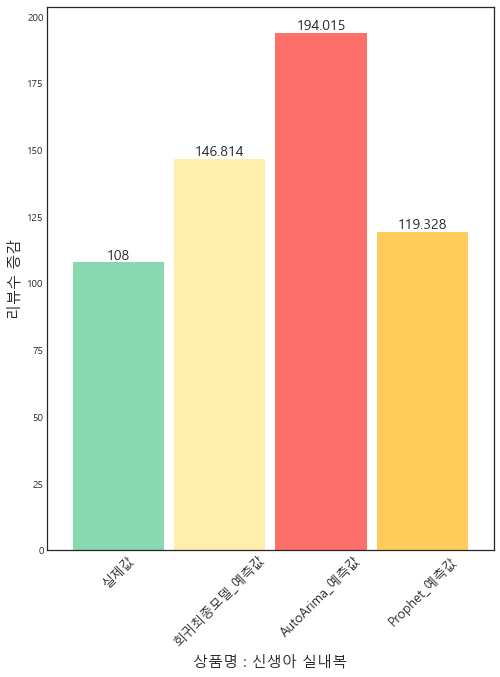

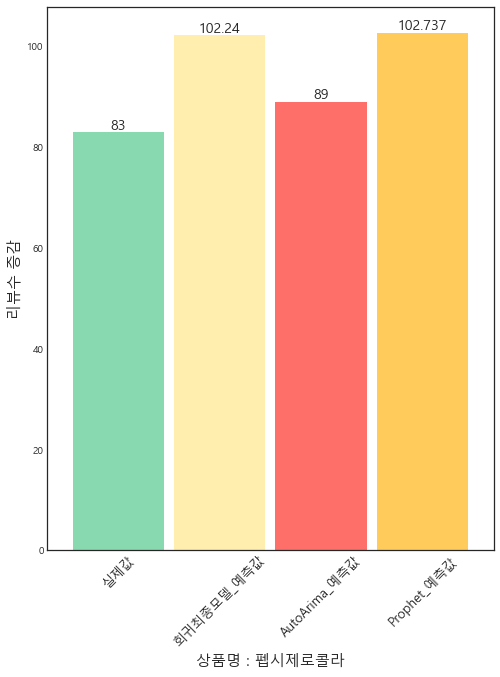

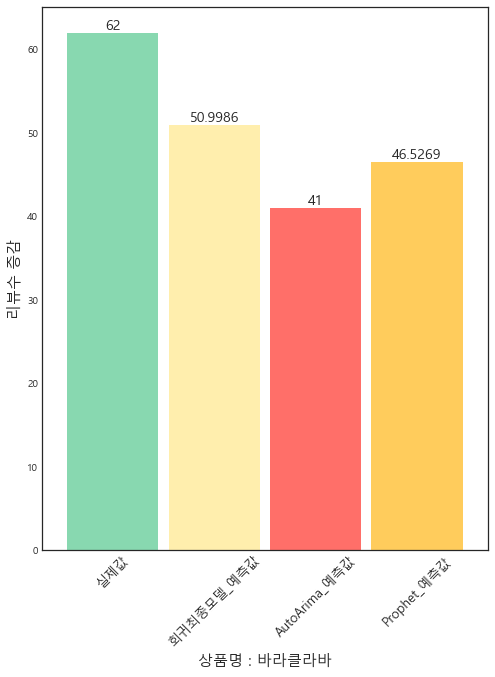

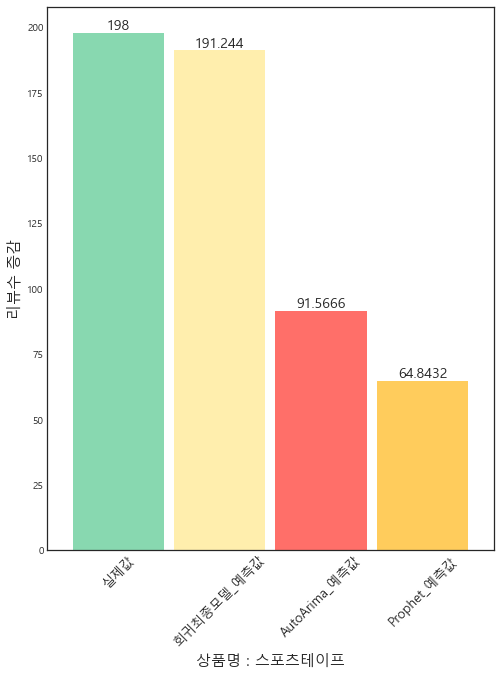

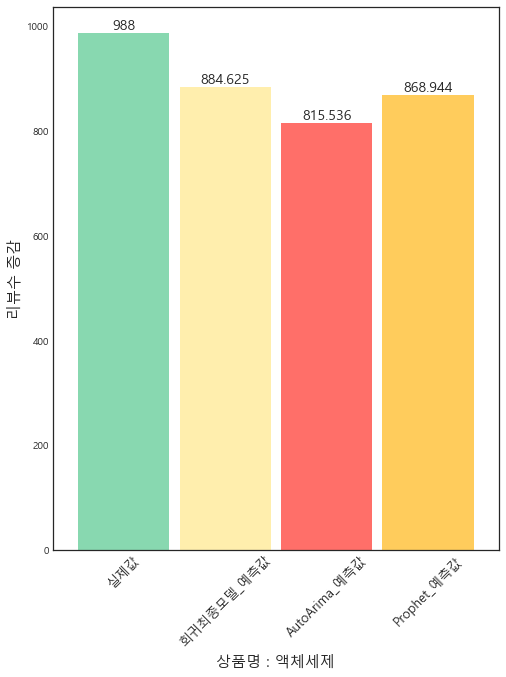

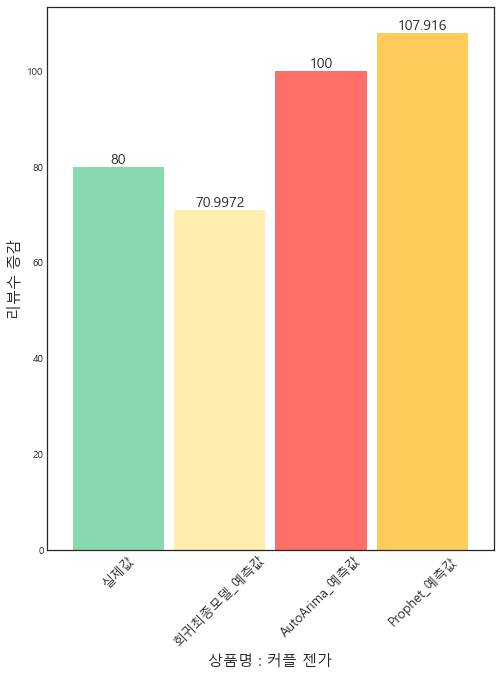

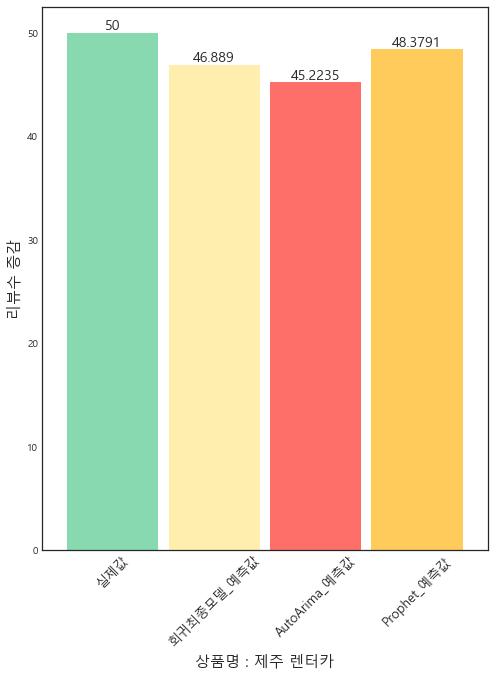

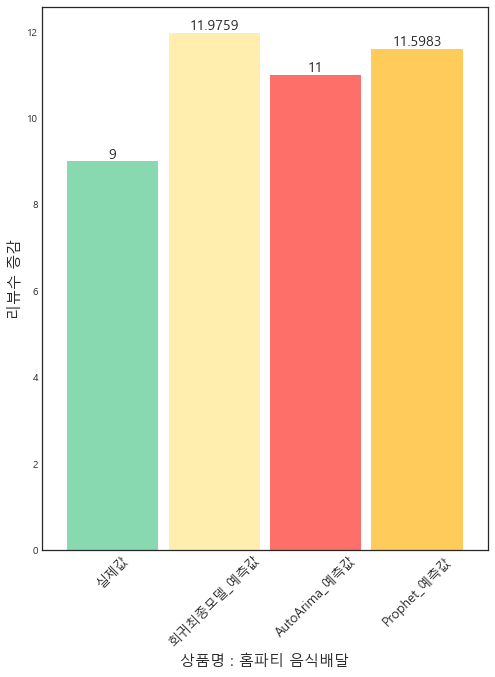

In [132]:
for i in range(len(validdf)):
    ax=validdf.iloc[i, :4].plot.bar(figsize=(8, 10), color=clrs, width=0.9)
    plt.xticks(rotation=45, fontsize=13)
    plt.xlabel(f'상품명 : {validdf.iloc[i, 4]}', fontsize=15)
    plt.ylabel('리뷰수 증감', fontsize=15)
    plt.bar_label(ax.containers[0], label_type='edge', fontsize=14)
    plt.show()

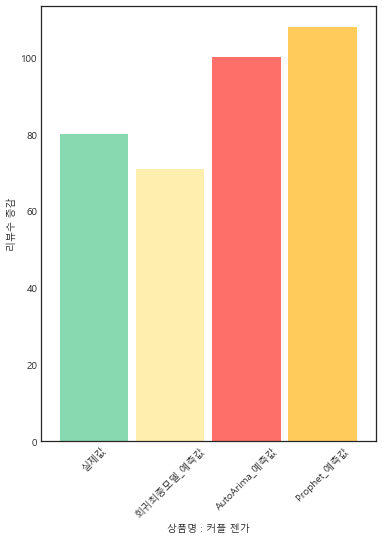

In [110]:
validdf.iloc[13, :4].plot.bar(figsize=(6, 8), color=clrs, width=0.9)
plt.xticks(rotation=45)
# plt.legend(loc=2, prop={'size': 15})
plt.xlabel('상품명 : 커플 젠가')
plt.ylabel('리뷰수 증감')
plt.show()

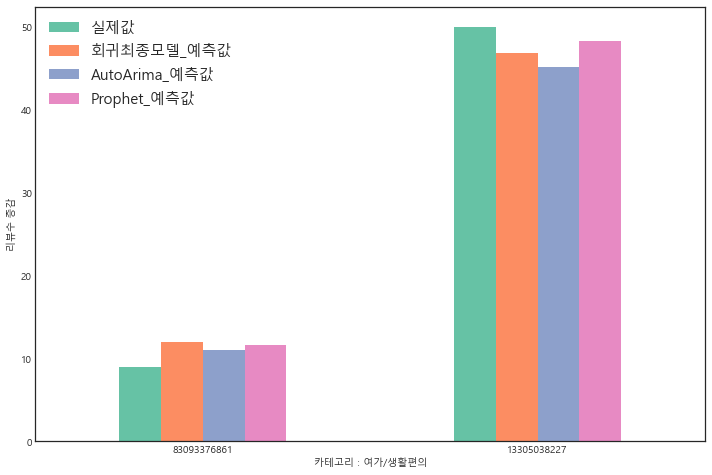

In [111]:
sns.set_palette('Set2')
validdf.iloc[[15, 14],].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=0)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('카테고리 : 여가/생활편의')
plt.ylabel('리뷰수 증감')
plt.show()

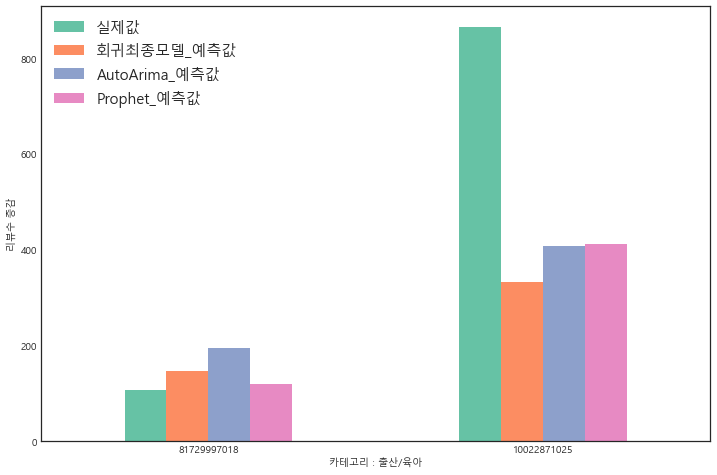

In [112]:
sns.set_palette('Set2')
validdf.iloc[[8, 7],].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=0)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('카테고리 : 출산/육아')
plt.ylabel('리뷰수 증감')
plt.show()

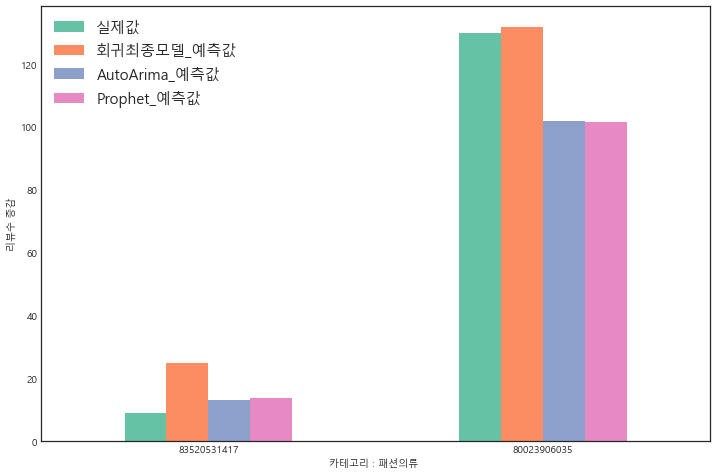

In [113]:
sns.set_palette('Set2')
validdf.iloc[[1, 0],].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=0)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('카테고리 : 패션의류 ')
plt.ylabel('리뷰수 증감')
plt.show()

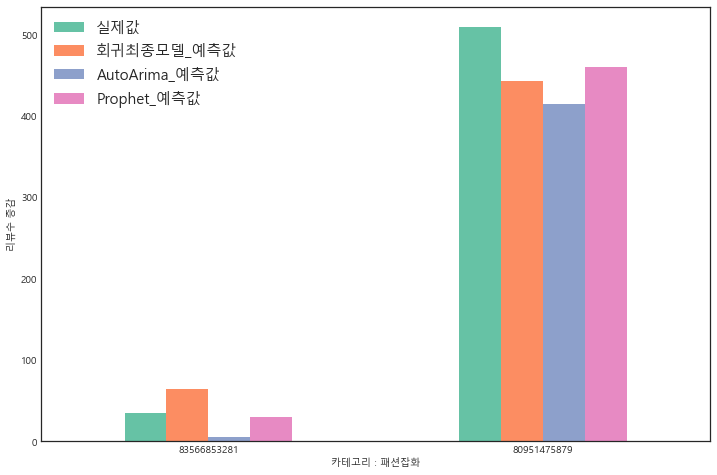

In [114]:
sns.set_palette('Set2')
validdf.iloc[[3, 2],].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=0)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('카테고리 : 패션잡화')
plt.ylabel('리뷰수 증감')
plt.show()

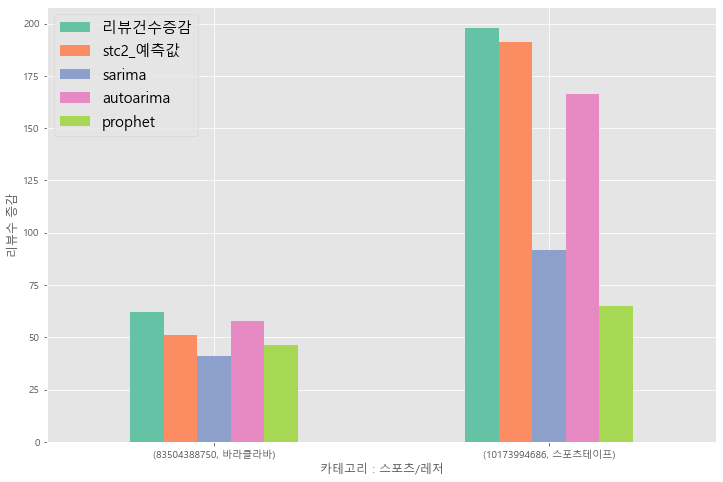

In [212]:
sns.set_palette('Set2')
validdf.iloc[[10, 11],].plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=0)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('카테고리 : 스포츠/레저')
plt.ylabel('리뷰수 증감')
plt.show()

## Learning Curves

In [42]:
train_sizes = [1, 100, 500, 2000, 3500,  5894]

In [68]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = x,
y = y, train_sizes = train_sizes, cv = kfold,
scoring = 'neg_root_mean_squared_error')

In [69]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[  -0.           -0.           -0.           -0.           -0.        ]
 [-108.57173635 -104.61139454  -68.7628083  -104.44809684 -103.99594415]
 [-101.92712095 -100.27885624  -90.80704564  -97.27816926  -96.05904699]
 [-234.60596018 -221.78065833 -219.89091538 -198.79214647 -229.09077184]
 [-225.78724839 -229.0497511  -227.72636442 -208.35681521 -226.46822679]
 [-221.11030235 -223.56595653 -223.11344394 -214.55371266 -224.6671471 ]]

 ----------------------------------------------------------------------

Validation scores:

 [[-233.58240623 -229.50986322 -222.88904177 -252.36452587 -219.06053866]
 [-226.62689626 -222.44532473 -223.0473898  -281.6117151  -235.50387519]
 [-292.35624962 -288.2883131  -298.93269651 -308.69153487 -272.65584877]
 [-218.55303179 -208.74238851 -210.15407248 -236.15972597 -210.34560189]
 [-215.71033196 -206.71914413 -208.04238982 -236.01978154 -203.78622848]
 [-215.04413769 -205.82141198 -206.92995907 -235.73514809 -203.10674409]]


In [72]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1        -0.000000
100      98.077996
500      97.270048
2000    220.832090
3500    223.477681
5894    221.402113
dtype: float64

 --------------------

Mean validation scores

 1       231.481275
100     237.847040
500     292.184929
2000    216.790964
3500    214.055575
5894    213.327480
dtype: float64


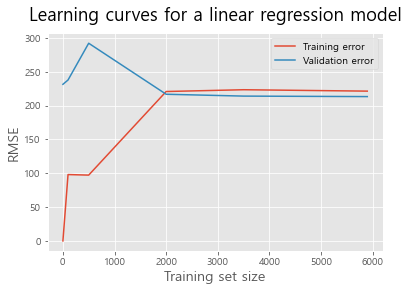

In [74]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [214]:
def learning_curves(estimator, train_sizes):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator,
        x,
        y,
        train_sizes=train_sizes,
        cv=kfold,
        scoring='neg_root_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, validation_scores_mean, label='Validation error')

    plt.ylabel('RMSE', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

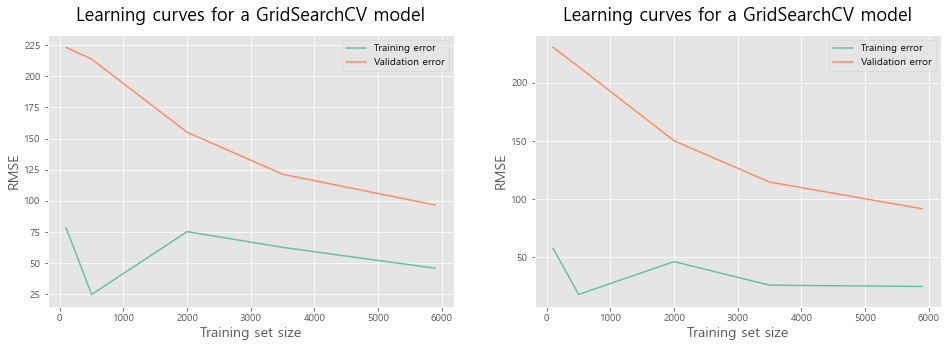

In [215]:
### Plotting the two learning curves ###
plt.figure(figsize=(16, 5))
for model, i in [(stc2, 1), (stc1, 2)]:
    plt.subplot(1, 2, i)
    learning_curves(model, train_sizes)

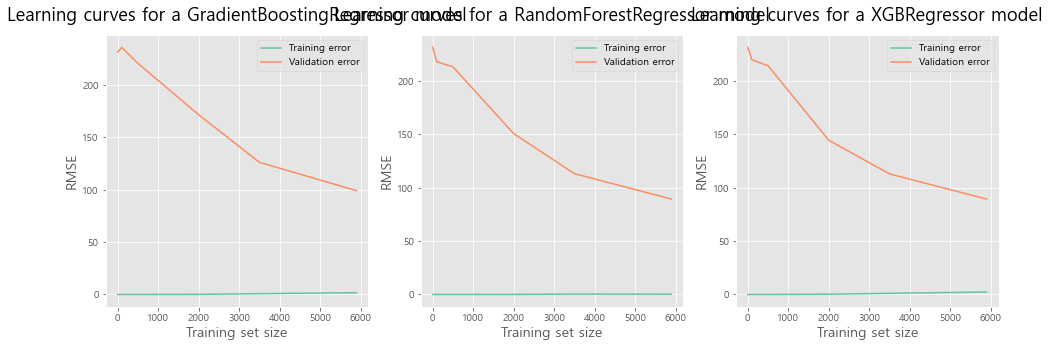

In [217]:
plt.figure(figsize=(16, 5))
for model, i in [(gbr_best, 1), (rf_best, 2), (xgb_best, 3)]:
    plt.subplot(1, 3, i)
    learning_curves(model, train_sizes)

## PCA

In [ ]:
display(x)
display(y)

In [ ]:
x = StandardScaler().fit_transform(x); x # 스탠다드 스케일링

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [ ]:
# pcadf = pd.concat([principalDf, df[['리뷰건수증감']]], axis=1); pcadf

In [ ]:
from sklearn import model_selection

In [ ]:
x_reduced = pca.fit_transform(scale(x))
regr = LinearRegression()
rmse = []

score = -1*model_selection.cross_val_score(regr,
           np.ones((len(x_reduced),1)), y, cv=kfold,
           scoring='neg_root_mean_squared_error').mean()    
rmse.append(score)

In [ ]:
for i in np.arange(1, 21):
    score = -1*model_selection.cross_val_score(regr,
               x_reduced[:,:i], y, cv=kfold, scoring='neg_root_mean_squared_error').mean()
    rmse.append(score)

In [ ]:
plt.plot(rmse)
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('hp')
plt.show()

In [ ]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

In [ ]:
from sklearn.preprocessing import scale 

In [ ]:
x_reduced_train = pca.fit_transform(scale(x_train))
x_reduced_test = pca.transform(scale(x_test))[:,:1]

In [ ]:
#train PCR model on training data 
regr = LinearRegression()
regr.fit(x_reduced_train[:,:1], y_train)

#calculate RMSE
pred = regr.predict(x_reduced_test)
mean_squared_error(y_test, pred, squared=False)

In [ ]:
r2_score(y_test, pred)